# SIM - Übungsblatt 2

## Aufgabe 2: Das Ising-Modell
Das Ising-Modell ist ein Modell der statistischen Physik zur Beschreibung der magnetischen Eigenschaften von Festkörpern. Es beschreibt insbesondere den Ferromagnetismus in Festkörpern (Kristallen). In dem Modell wird angenommen, dass die Spins, welche das magnetische Moment der Atome oder Ionen bestimmen, nur zwei diskrete Zustände annehmen können (+1 oder -1). Die Energiefunktion ist gegeben durch

&emsp;&emsp;$\begin{align}
  H(\vec s) = -\frac12 \sum J_{ij}s_is_j - H_n\sum_{i=1}^n
\end{align}$

wobei wir den zweiten Term vernachlässigen ($H_n=0$) und beim ersten Term nur eine Nächste-Nachbar-Wechselwirkung verwenden, d.h.

&emsp;&emsp;$\begin{align}
  J_{ij} = \left\{\begin{array}{ll}
    J_0 & ,\mbox{falls }i,j \mbox{ benachbart}\\
    0   & ,\mbox{sonst} 
  \end{array}\right.
\end{align}$

Minimieren Sie die Energiefunktion für das Ising-Modell in 2 Dimensionen mittels Simulated Annealing und visualisieren Sie das Ergebnis. Betrachten Sie dabei jeweils Ferromagneten ($J_0=+1$) und Antiferromagneten ($J_0 = -1$).

Wie verhält sich die Optimierung in Abhängigkeit von der Temperatur? Gibt es Temperaturen, die besonders interessant sind?

### Lösung:
Zunächst notwendige Biblitheken implementieren

In [13]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

Dann wird das Problem initialisiert und der Ausgangszustand visualisiert. Gespeichert werden die Spins in einer Spinmatrix $s[i,j]$

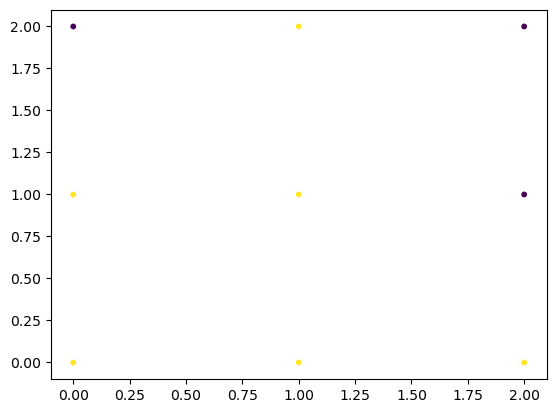

In [23]:
# Größe und Wechselwirkung festlegen
n=3
J0=1

# Genereriere Spin-Matrix
s = (np.random.uniform(0,1,[n,n])>0.5) * 2 - 1

# Hilfsgroessen für Scatter-Plot
x=np.zeros_like(s)
y=np.zeros_like(s)
for i in np.arange(n):
    x[:,i]=i
    y[i,:]=i
    
# Spin-Matrix plotten
plt.scatter(x, y, c=s, s=10)
plt.show()

Berechnung der initialen Energie

In [24]:
so = np.roll(s,-1,0)
su = np.roll(s, 1,0)
sl = np.roll(s,-1,1)
sr = np.roll(s, 1,1)
H = -J0 * (s*so + s*su + s*sl + s*sr)
E_start = H.sum()
print(E_start)

[[ 1  1  1]
 [ 1  1 -1]
 [-1  1 -1]]
[[ 1  1 -1]
 [-1  1 -1]
 [ 1  1  1]]
[[ 1  1 -1]
 [-1  1  1]
 [-1  1 -1]]
[[-2 -4  0]
 [ 0 -2  2]
 [ 2  0  0]]
-4


Funktion zur Berechnung der Energiedifferenz bei der Änderung eines Spins. Durch diese Delta-Berechnung erhalten wir die benötigte Performance.

In [4]:
def deltaEnergy(J0,s,i,j):
    n = s.shape[0]
    
    # nur benachbarte Spins betrachten
    jo = (j>0)  *(j-1) + (j==0)   * (n-1)
    ju = (j<n-1)*(j+1) + (j==n-1) * 0
    il = (i>0)  *(i-1) + (i==0)   * (n-1)
    ir = (i<n-1)*(i+1) + (i==n-1) * 0

    # Teilenergie dieses Spins
    h = -J0 * s[i,j] * (s[i,jo] + s[i,ju] + s[il,j] + s[ir,j]);
    
    # Delta zurüchgeben
    return -2*h

Funkionen für die verschiedenen Cooling-Schedules

In [5]:
def mkCoolingScheduleLin(T0,K,iter):
    T = np.ones(iter)*T0
    dT = T0/(iter/K)
    
    for k in np.arange(2,iter):
        T[k] = T[k-1]
        if k%K == 0:
            T[k] -= dT
            
    return T           

In [6]:
def mkCoolingScheduleBilin(T0,K,iter,T1,T2,anteil1,anteil2):
    T = np.ones(iter)*T0;
    
    # Normierung
    k1 = iter * (anteil1/1)
    k2 = iter * (anteil2/1)
    #print(anteil,k1,k2,iter)
    
    for k in np.arange(2,iter):
        T[k] = T[k-1]
        dT = 0
        
        if k%K == 0:
            if k<k1:
                dT = -(T1-T0)/(k1- 0)*K
            elif k<k2:
                dT = -(T2-T1)/(k2-k1)*K
            else:
                dT = -(0 -T2)/(iter-k2)*K            
            
            T[k] -= dT

        if T[k]<0:
            T[k]=0
            
    return T

In [7]:
def mkCoolingScheduleExp(T0,K,iter,Te):
    T = np.ones(iter)*T0;

    λ = -1/iter * np.log(Te/T0)
    
    for k in np.arange(2,iter):
        T[k] = T[k-1]
        
        if k%K == 0:
            T[k] = T0 * np.exp(-λ*k)
    
    return T

Hilfsfunktion für regelmäßigen Output

In [8]:
def plotFigures(s,k,T,E,var):
    # Berechnung der Suszeptibilität 
    # (als gleitender Mittelwert)
    span = 1000
    sus  = np.convolve(var, np.ones(span), 'valid') / span
    Tsus = T[span//2:-(span//2-1)]

    # Multiplot
    plt.clf()
    plt.suptitle(f"k={k}, T={T[k]:.2f}, E={E[k]:.0f}")

    # 1. Plot: Spins anzeigen
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax1.scatter(x, y, c=s, s=10, cmap='viridis')
    ax1.set_xticks([])
    ax1.set_yticks([])

    # 2. Plot: Energie über Iterationen
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax2.plot(E)
    ax2.set_xlabel("k")
    ax2.set_ylabel("E")

    # 3. Plot: Suszeptibilität über Temperatur
    ax3 = plt.subplot2grid((2, 2), (0, 1))
    ax3.plot(Tsus,sus)
    ax3.invert_xaxis()
    ax3.yaxis.tick_right()
    ax3.set_ylim(0,1.5*np.max(sus[0:-sus.size//10]))
    ax3.set_xlabel("T")
    ax3.set_ylabel("var")
    ax3.yaxis.set_label_position("right")

    # 4. Plot: Energie über Temperatur
    ax4 = plt.subplot2grid((2, 2), (1, 1))
    ax4.plot(T,E)
    ax4.invert_xaxis()
    ax4.set_xlabel("T")
    ax4.set_ylabel("E")
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()

    # online anzeigen
    display.display(plt.gcf())
    display.clear_output(wait=True)

Definition der Rahmenbedingungen und Auswahl des verwendeten Cooling-Schedules

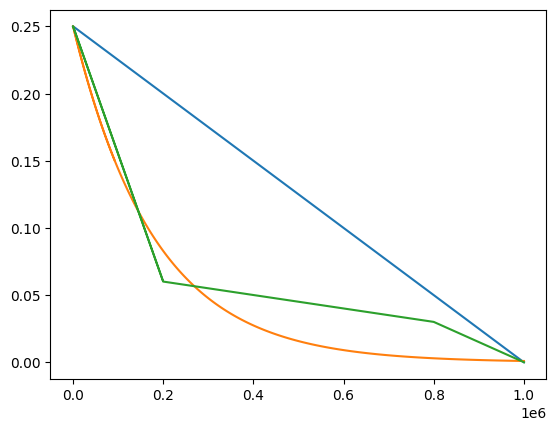

In [9]:
iter = int(1E6) # Anz. Iterationen
T0 = 0.25         # Starttemperatur
K = 100         # Kettenlänge

T_lin = mkCoolingScheduleLin(T0,K,iter)
T_exp = mkCoolingScheduleExp(T0,K,iter,.001)
T_bil = mkCoolingScheduleBilin(T0,K,iter,0.06,0.03,.2,.8) 

plt.figure()
plt.plot(T_lin)
plt.plot(T_exp)
plt.plot(T_bil)

T=T_exp

Das ist der komplette Simulated Annealing Algorithmus. Wie man sieht, ist der völlig unabhängig von der Zielfunktion.
Der Schrittvorschlager ist in die Schleife integriert, könnte aber auch ausgelagert werden.

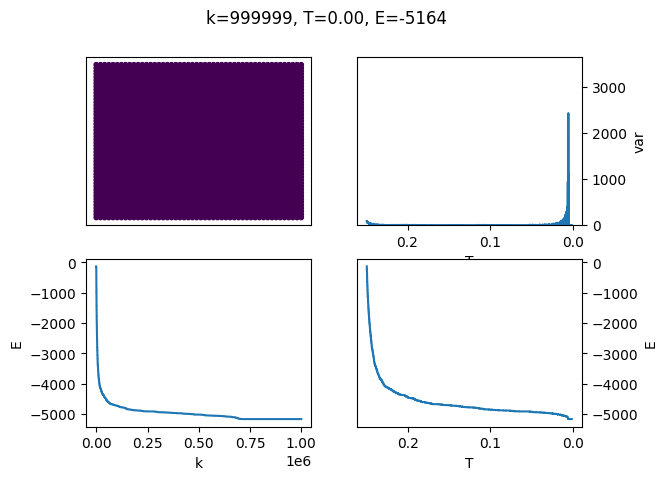

In [10]:
# Spins zurücksetzen
s = (np.random.uniform(0,1,[n,n])>0.5) * 2 - 1

# Generierung der Zufallszahlen
irand = np.random.uniform(0,n,[iter]).astype(int)
jrand = np.random.uniform(0,n,[iter]).astype(int)
Prand = np.random.uniform(0,1,[iter])

# Initialisierung benötigter Vektoren
E   = np.zeros([iter])
var = np.zeros([iter])

# Ergebnis darstellen (Vorsicht!)
plotSteps=20;

E[0] = E_start
for k in np.arange(1,iter):
    i,j = irand[k],jrand[k]
    
    # Berechnung der Ennergiedifferenz
    # (schneller als komplette Berechnung)
    dE = deltaEnergy(J0,s,i,j)

    if dE<0 or (T[k]>0 and Prand[k]<np.exp(-dE/T[k])):
        
        # Move durchführen
        s[i,j] = -s[i,j] 
        
        # Energie speichern
        E[k] = E[k-1] + dE
        
        # Varianz berechnen
        var[k] = dE**2 / T[k]**2
        
    else:
        #  move wird nicht ausgeführt, Energie bleibt unverändert
        E[k] = E[k-1]
        
    # Zwischeninfomationen ausgeben
    if k%(iter//plotSteps)==0 or k==iter-1:
        plotFigures(s,k,T,E,var)
        

Feinere Analyse zur Verbesserung der Cooling Schedules:

Text(0, 0.5, 'var')

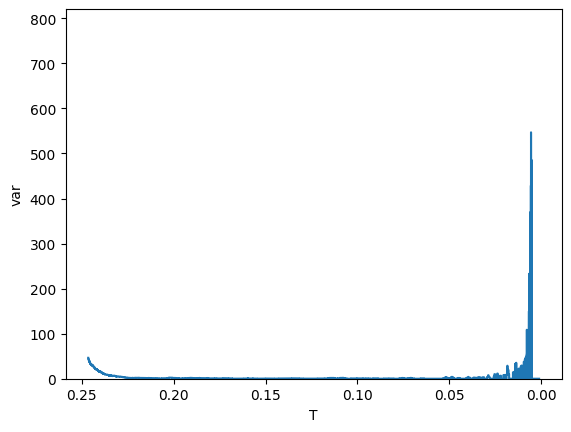

In [11]:
span = 5000
sus  = np.convolve(var, np.ones(span), 'valid') / span
Emed  = np.convolve(E, np.ones(span), 'valid') / span
Tsus = T[span//2:-(span//2-1)]

plt.figure()
plt.axes().invert_xaxis()
plt.plot(Tsus,sus)
plt.ylim(0,1.5*np.max(sus[0:-sus.size//10]))
plt.xlabel("T")
plt.ylabel("var")